<a href="https://colab.research.google.com/github/photochemistry/edamame-dev/blob/main/dev/grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# import sys
# try:
    # from google.colab import drive
    # drive.mount('/content/drive')
    # ColabでGoogleDrive越しで使う場合。
    # BASEPATH = "/content/drive/MyDrive/DataAnalysis/"
    # geopandasはGIS情報をPandasのように扱うライブラリ
    # ffmpegは画像を束ねて動画にするツール
%pip install geopandas ffmpeg-python
%pip install git+https://github.com/photochemistry/edamame-dev.git
    # sys.path.insert(0,"/content/drive/MyDrive/DataAnalysis/edamame/dev")

# except:
#     # ローカルディスク上でJupyterで使う場合。
#     BASEPATH = "../../"

# BASEPATH, sys.path


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/photochemistry/edamame-dev.git to /tmp/pip-req-build-hiccffid
  Running command git clone --filter=blob:none --quiet https://github.com/photochemistry/edamame-dev.git /tmp/pip-req-build-hiccffid
  Resolved https://github.com/photochemistry/edamame-dev.git to commit def9bee36cb8c51d5ad409de69461402c210f95b
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See 

In [14]:
! pip uninstall -y edamame-dev
! pip install git+https://github.com/photochemistry/edamame-dev.git

Found existing installation: edamame-dev 0.1
Uninstalling edamame-dev-0.1:
  Successfully uninstalled edamame-dev-0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/photochemistry/edamame-dev.git to /tmp/pip-req-build-unls3wt3
  Running command git clone --filter=blob:none --quiet https://github.com/photochemistry/edamame-dev.git /tmp/pip-req-build-unls3wt3
  Resolved https://github.com/photochemistry/edamame-dev.git to commit 3e06024015fc392d398ff521a440c9c3dbbed088
  Preparing metadata (setup.py) ... done
  Created wheel for edamame-dev: filename=edamame_dev-0.1-py3-none-any.whl size=5342 sha256=fcaf03ae5b9208c2461892435c8f4ef14372784ae9db0a1aa221f504a4c24b1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-g2dyk_ca/wheels/bc/df/68/3931aa5648aa4921f82d229b17f5cbc72ca00770951896645e
Successfully built edamame-dev


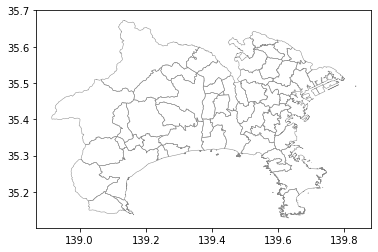

In [15]:
from edamame import dev
import matplotlib.pyplot as plt

# DataAnalysisフォルダー内での相対位置
shape = "http://www.chem.okayama-u.ac.jp/~reg/edamame-data/14/N03-20210101_14_GML/N03-21_14_210101.geojson"

elems = dev.perimeters(plt, shape)

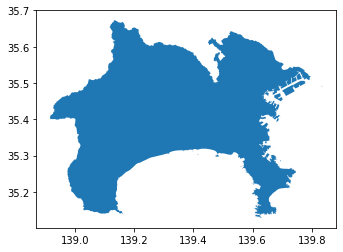

In [16]:
import geopandas as gpd

gdf3 = gpd.read_file(shape)

# 陸地全域をlandとする。
# 小領域を融合してくれる便利な関数dissolve()
land = gdf3[['geometry']].dissolve()

land.plot()

格子点を生成する。陸地上でない格子点は排除する。

最寄りの測定局からの距離を重みとして用いて、学習時には信頼性の高い点を優先させたい。

(Colabではかなり時間がかかる処理)

In [17]:
gX, gY = dev.make_grid(shape)


[False False False ... False False False] 738


In [18]:
import datetime
import numpy as np

####### ここで、表示する物質を選ぶ。  ######
target = "WS"
target = "CH4"
# 風の場合のみ、ちょっと違う処理が必要

timeorigin = datetime.datetime(year=2020, month=6, day=4, hour=0, tzinfo=None)
hours = 24

stations = dict()
stations |= dev.station_info(pref=14, target=target, PATH="http://www.chem.okayama-u.ac.jp/~reg/edamame-data/")
stations |= dev.station_info(pref=13, target=target, PATH="http://www.chem.okayama-u.ac.jp/~reg/edamame-data/")
stations |= dev.station_info(pref=19, target=target, PATH="http://www.chem.okayama-u.ac.jp/~reg/edamame-data/")
stations |= dev.station_info(pref=22, target=target, PATH="http://www.chem.okayama-u.ac.jp/~reg/edamame-data/")
values = dict()
for loc, station in stations.items():
    df = dev.retrieve(loc, timeorigin + datetime.timedelta(hours=hours), hours=hours, PATH="http://www.chem.okayama-u.ac.jp/~reg/edamame-data/")
    if df is not None:
        values[loc] = df



/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


TypeError: ignored

In [ ]:
values.keys()

In [ ]:
v = np.array([df[target] for loc, df in values.items()])
v = v[~np.isnan(v)]

avg = v.mean()
std = v.std()
maxvalue = avg+std*2
minvalue = avg-std*2

# 色付け関数
vcolorify = np.vectorize(lambda x: dev.colorify(x, min=minvalue, max=maxvalue))

minvalue, maxvalue


In [ ]:
def draw1(h):
    print(h)
    fig, ax = plt.subplots()
    ax.set_xlim(138.9, 139.8)
    ax.set_ylim(35.1, 35.7)
    dev.draw(target, h, ax, gX, gY, values, stations, vcolorify, shape)
    plt.show()
    

# scatter(0, ax)

スライダーで24時間分を表示。


In [ ]:
from ipywidgets import interact

interact(draw1, h=(0,24))

interactive(children=(IntSlider(value=12, description='h', max=24), Output()), _dom_classes=('widget-interact'…

<function __main__.draw1(h)>

0


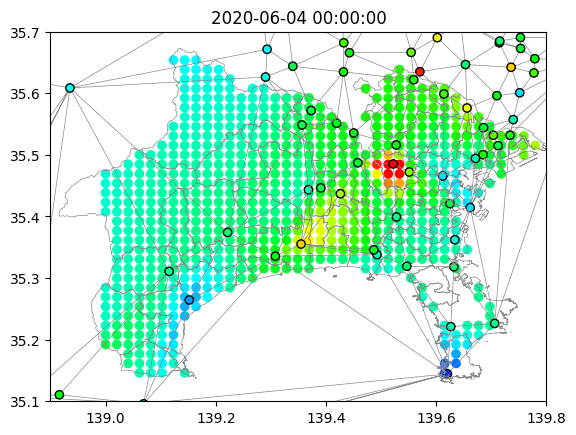

In [ ]:
draw1(0)